# National Park Problem

## Part (a): Shortest Path Problem

### Import Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

### Data Preprocessing

In [2]:
node_names = ["Origin", "A", "B", "C", "D", "E", "Destination"]
nodes = range(7)
edges = {(0, 1): 40, (0, 2): 60, (0, 3): 50,
         (1, 2): 10, (1, 4): 70, (2, 3): 20,
         (2, 4): 55, (2, 5): 40, (3, 5): 50,
         (4, 5): 10, (4, 6): 60, (5, 6): 80}

# manually set the node position to make the graph more aesthetically pleasing
pos_custom = {
    0: (0, 0.5),  
    1: (1, 1),   
    2: (1, 0.5), 
    3: (1, 0), 
    4: (2, 0.75), 
    5: (2, 0.25),
    6: (3, 0.5)   
}

### Graph Visualization

In [3]:
def show_graph(nodes, edges, shortest_path=None, pos_custom=None):
    # Create a new directed graph
    g = nx.DiGraph()
    
    # Add nodes and edges with weights
    g.add_nodes_from(nodes)
    for edge, weight in edges.items():
        g.add_edge(*edge, weight=weight)
    
    # Position nodes using the spring layout for aesthetic purposes
    if pos_custom is None:
        pos = nx.spring_layout(g)
    else:
        pos = pos_custom
    
    # Draw the graph with custom positions
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_edges(g, pos, edge_color='gray', arrowsize=30)
    edge_labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

    # show all nodes
    nx.draw_networkx_nodes(g, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(g, pos)

    # highlight the shortest path if provided
    if shortest_path and isinstance(shortest_path, list) and len(shortest_path) > 1:
        path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
        nx.draw_networkx_edges(g, pos, edgelist=path_edges, edge_color='violet', width=2, arrowsize=30)
        nx.draw_networkx_nodes(g, pos, nodelist=shortest_path, node_color='violet', node_size=700)

    plt.title('Graph of National Park Problem')
    plt.axis('off')
    plt.show()

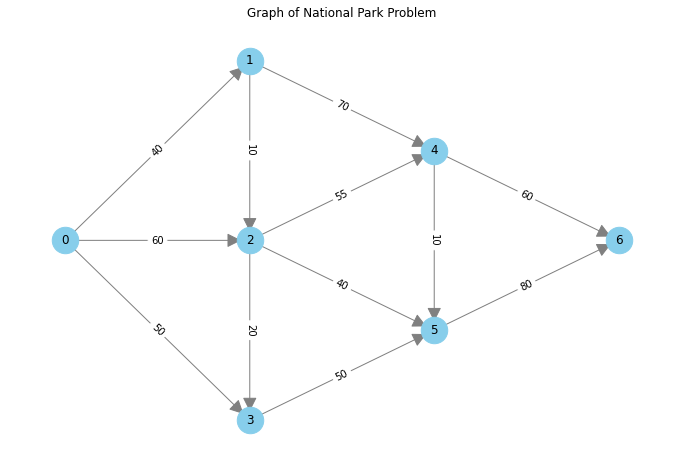

In [4]:
show_graph(nodes=nodes, edges=edges, pos_custom=pos_custom)

### Construct the Model

In [5]:
def shortest_path(nodes, edges):
    # create a model
    model = pyo.ConcreteModel("Shortest Path Problem")

    # decision variables
    model.x = pyo.Var(edges.keys(), domain=pyo.Binary)

    # objective function
    model.obj = pyo.Objective(expr=sum(model.x[i] * edges[i] for i in edges.keys()), sense=pyo.minimize)

    # constraints
    # build a constraint list
    model.cons = pyo.ConstraintList()
    # constraints for A, B, C, D, E
    for n in nodes:
        if n in [0, len(nodes) - 1]:
            continue
        model.cons.add(
            sum(model.x[(i, j)] for i, j in edges if j == n) ==
            sum(model.x[(i, j)] for i, j in edges if i == n)
        )
    # constraints of origin and destination
    model.cons.add(sum(model.x[(0, j)] for j in nodes if (0, j) in edges) == 1)
    model.cons.add(sum(model.x[(i, 6)] for i in nodes if (i, 6) in edges) == 1)

    return model

### Solve the Model

In [6]:
def solve_model(model):
    SOLVER.solve(model)
    model.display()

In [7]:
model1 = shortest_path(nodes, edges)
solve_model(model1)

Model Shortest Path Problem

  Variables:
    x : Size=12, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 1) :     0 :   1.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   1.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 4) :     0 :   1.0 :     1 : False : False : Binary
        (2, 5) :     0 :   0.0 :     1 : False : False : Binary
        (3, 5) :     0 :   0.0 :     1 : False : False : Binary
        (4, 5) :     0 :   0.0 :     1 : False : False : Binary
        (4, 6) :     0 :   1.0 :     1 : False : False : Binary
        (5, 6) :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        

### Result Visualization

In [8]:
def shortest_path_visualization(model):
    print("The shortest path is: ")
    flag = True
    shortest_path = []
    for i in edges.keys():
        if model1.x[i].value > 0:
            if flag:
                print(f"{i[0]} \u2192 {i[1]}", end=" ")
                shortest_path.append(i[0])
                shortest_path.append(i[1])
                flag = False
            else:
                print(f"\u2192 {i[1]}", end=" ")
                shortest_path.append(i[1])
    
    print()
    flag = True
    for i in edges.keys():
        if model1.x[i].value > 0:
            if flag:
                print(f"{node_names[i[0]]} \u2192 {node_names[i[1]]}", end=" ")
                flag = False
            else:
                print(f"\u2192 {node_names[i[1]]}", end=" ")
    print()
    print(f"\nThe total length of shortest path is {pyo.value(model.obj)}. ")
    
    return shortest_path

In [9]:
shortest_path = shortest_path_visualization(model1)

The shortest path is: 
0 → 1 → 2 → 4 → 6 
Origin → A → B → D → Destination 

The total length of shortest path is 165.0. 


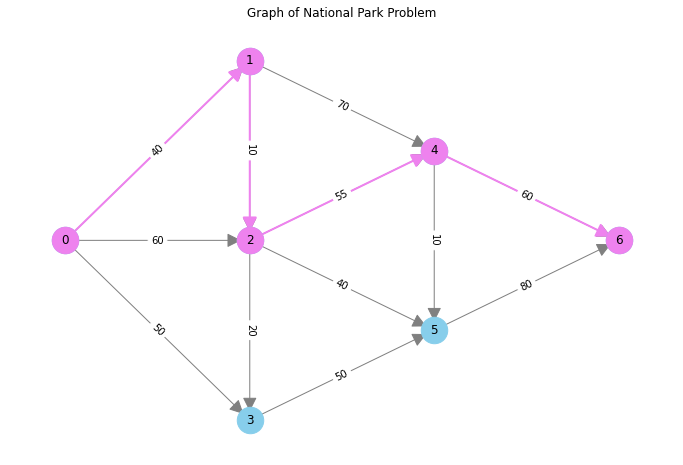

In [10]:
show_graph(nodes=nodes, edges=edges, shortest_path=shortest_path, pos_custom=pos_custom)

## Part (b): Max-flow Problem

### Data Preprocessing

In [11]:
edges[(6, 0)] = None

### Graph Visualization

In [12]:
def show_modified_graph(nodes, edges, pos_custom=None, curved_edge=[(6, 0)]):
    new_edges = edges.copy()
    for curved in curved_edge:
        if curved in new_edges:
            del new_edges[curved]
            
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    for edge, weight in new_edges.items():
        g.add_edge(*edge, weight=weight)

    if pos_custom is None:
        pos = nx.spring_layout(g)
    else:
        pos = pos_custom

    plt.figure(figsize=(12, 8))
    straight_edges = [edge for edge in g.edges() if edge not in curved_edge]
    nx.draw_networkx_edges(g, pos, edgelist=straight_edges, edge_color='gray', arrowsize=30)
    
    for curved in curved_edge:
        nx.draw_networkx_edges(g, pos, edgelist=[curved], edge_color='gray', connectionstyle='arc3,rad=0.3', arrowsize=30)

    nx.draw_networkx_nodes(g, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(g, pos)
    edge_labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

    plt.title('Max-flow Problem')
    plt.axis('off')
    plt.show()

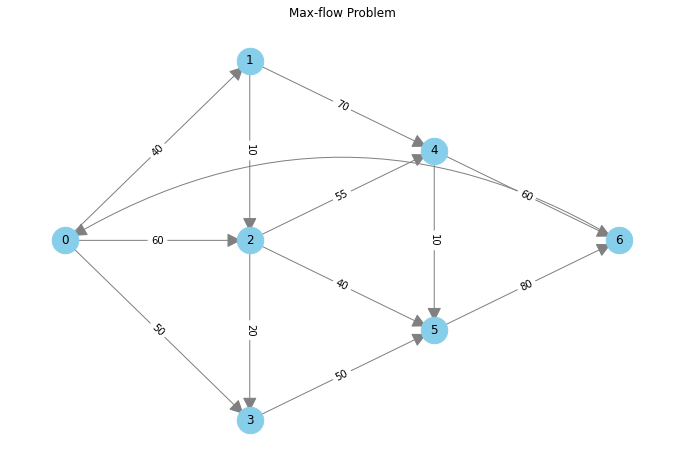

In [13]:
show_modified_graph(nodes=nodes, edges=edges, pos_custom=pos_custom)

### Construct the Model

In [14]:
def max_flow(nodes, edges):
    # create a model
    model = pyo.ConcreteModel("Max-flow Problem")

    # decision variables
    model.x = pyo.Var(edges.keys(), domain=pyo.NonNegativeReals)

    # objective function
    model.obj = pyo.Objective(expr=-model.x[(len(nodes)-1, 0)], sense=pyo.minimize)

    # constraints
    # build a constraint list
    model.cons = pyo.ConstraintList()
    # constraints for edges
    for (i, j) in edges:
        model.x[(i, j)].setub(edges[(i, j)])
    # constraints for nodes
    for n in nodes:
        model.cons.add(
            sum(model.x[(i, j)] for i, j in edges if j == n) ==
            sum(model.x[(i, j)] for i, j in edges if i == n)
        )

    return model

### Solve the Problem

In [15]:
model2 = max_flow(nodes, edges)
solve_model(model2)

Model Max-flow Problem

  Variables:
    x : Size=13, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 1) :     0 :  40.0 :    40 : False : False : NonNegativeReals
        (0, 2) :     0 :  50.0 :    60 : False : False : NonNegativeReals
        (0, 3) :     0 :  50.0 :    50 : False : False : NonNegativeReals
        (1, 2) :     0 :   0.0 :    10 : False : False : NonNegativeReals
        (1, 4) :     0 :  40.0 :    70 : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :    20 : False : False : NonNegativeReals
        (2, 4) :     0 :  20.0 :    55 : False : False : NonNegativeReals
        (2, 5) :     0 :  30.0 :    40 : False : False : NonNegativeReals
        (3, 5) :     0 :  50.0 :    50 : False : False : NonNegativeReals
        (4, 5) :     0 :   0.0 :    10 : False : False : NonNegativeReals
        (4, 6) :     0 :  60.0 :    60 : False : False : NonNegativeReals
        (5, 6) :     0 :  80.0 :    80 : False : False

### Result Visualization

In [16]:
print(f"The max-flow is {-pyo.value(model2.obj)}. ")

The max-flow is 140.0. 


In [17]:
flow_solution = {edge: model2.x[edge].value for edge in model2.x}
del flow_solution[(6, 0)]
flow_solution

{(0, 1): 40.0,
 (2, 4): 20.0,
 (1, 2): 0.0,
 (0, 3): 50.0,
 (4, 6): 60.0,
 (1, 4): 40.0,
 (2, 3): 0.0,
 (0, 2): 50.0,
 (4, 5): 0.0,
 (5, 6): 80.0,
 (2, 5): 30.0,
 (3, 5): 50.0}

In [20]:
def show_max_flow_graph(nodes, edges, flow_solution, pos_custom=None):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    
    if (len(nodes)-1, 0) in edges.keys():
        del edges[(len(nodes)-1, 0)]
    for edge, capacity in edges.items():
        flow = flow_solution[edge] if edge in flow_solution else 0
        G.add_edge(*edge, capacity=capacity, flow=flow)

    if pos_custom is None:
        pos = nx.spring_layout(G)
    else:
        pos = pos_custom
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', arrowsize=20)
    
    edge_labels = {(u, v): f'{G[u][v]["flow"]:.0f}/{G[u][v]["capacity"]}' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title('Max Flow Problem Result with Capacity and Flow')
    plt.axis('off')  
    plt.show()

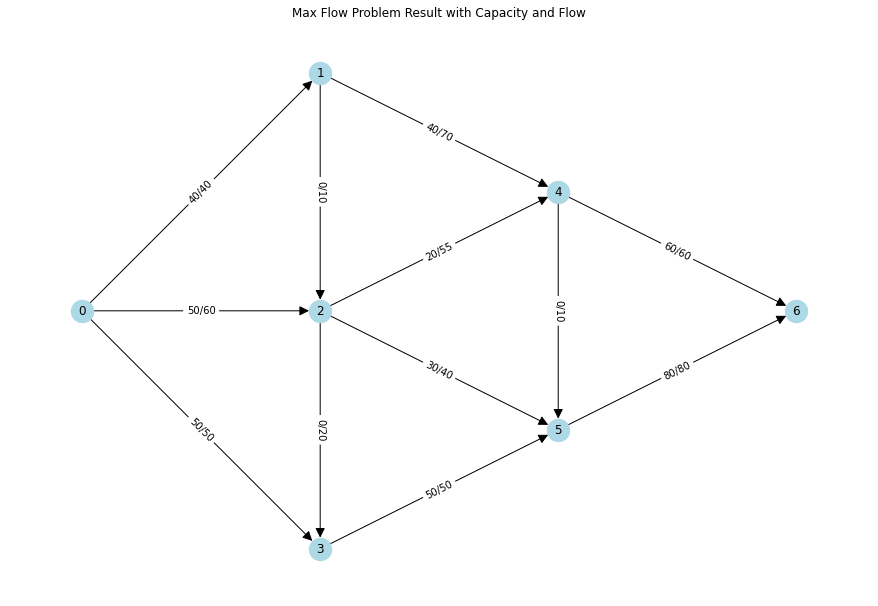

In [21]:
show_max_flow_graph(nodes, edges, flow_solution, pos_custom=pos_custom)